CS524: Introduction to Optimization Lecture 28
======================================

## Michael Ferris<br> Computer Sciences Department <br> University of Wisconsin-Madison

## November 6, 2024
--------------

# LQR control: a structured QP

$$
\min \int_0^1 6 u(t)^2 + 2x_1(t)^2 + x_2(t)^2 \, \mbox{d}t,
$$
$$ 
\begin{bmatrix} \dot{x_1} \\
\dot{x_2} \end{bmatrix} = 
\begin{bmatrix} x_2 \\ -x_1 + u \end{bmatrix},
$$
$$
|u(t)| \le U, \;\; x_1(0) = 15, \;\; x_2(0) = 5,
$$

where $U$ is a positive constant.  Start with a linear ODE and its
solution, introduce concept of an input/control $u$ that influences
the evolution of the ODE, objective function and constraints to guide
$x$ to a particular goal.

# Euler discretization

We use Euler discretization to model the derivatives:
$$ \dot{x} = 
\frac{x^{t+1} - x^t}{\delta t} 
$$

$$
\dot{x} = Ax+Bu
$$
$$ \frac{x_1^{t+1}-x_1^t}{\delta t} = x_2^t
$$
$$ \frac{x_2^{t+1}-x_2^t}{\delta t} = -x_1^t+u^t
$$
leads to
$$ \frac{x^{t+1}-x^t}{\delta t} = Ax^t+Bu^t
$$

Read in data and plot.
Push data into gamspy environment.

In [1]:
import gamspy as gp
from gamspy import Sum

import sys
import numpy as np

options = gp.Options(equation_listing_limit=20)
m = gp.Container(options=options)

# Set the number of stages and control bound to the desired value 
T = m.addParameter('T',records=200)
stages = m.addSet('stages',records=range(0,int(T.toValue())+1))
Ubound = m.addParameter('Ubound',records=0.1)

Discuss the structure and detail the QP. 

We approximate the integral using the trapezoidal rule (see https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [ ]:
states = m.addSet('states',records=[1,2])
inputs = m.addSet('inputs',records=[1])
j = m.addAlias('j',states)
i = m.addAlias('i',inputs)

Xinitial = m.addParameter('Xinitial',domain=states,description='initial X',
    records = [(1,15), (2, 5)])

deltaT = m.addParameter('deltaT', description='set interval width deltaT to be 1/T')
deltaT[:] = 1.0 / T;

Q = m.addParameter('Q', domain=[states,states],description='Hessian wrt states',
    records=np.array([
        [2.0,   0.0],
        [0.0,   1.0]]))

R = m.addParameter('R', domain=[inputs,inputs],description='Hessian wrt inputs',
    records=np.array([
        [6.0]]))

A = m.addParameter('A', domain=[states,states],description='state transition matrix in continuous formulation',
    records=np.array([
        [0.0,   1.0],
        [-1.0,  0.0]]))

B = m.addParameter('B', domain=[states,inputs],description='input transition matrix in continuous formulation',
    records=np.array([
        [0.0],
        [1.0]]))

x = m.addVariable('x',domain=[stages, states],description="state variables")
u = m.addVariable('u',domain=[stages, inputs],description="input variables (controls)")

state = m.addEquation('state', domain=[stages,states],description='state transition equation')
state[stages, states].where[~stages.last]= (
    (x[stages.lead(1), states] - x[stages, states] ) / deltaT
          == Sum(j, A[states, j]*x[stages,j])
             + Sum(i, B[states, i]*u[stages,i]) )

# objective contains integral using trapezoidal rule on [0,1]
lqr = m.addModel('lqr',
    equations=m.getEquations(),
    problem=gp.Problem.QCP,
    sense=gp.Sense.MIN,
    objective = ((1/2) * deltaT *
        (Sum(stages.where[~stages.last],
        Sum([states,j], x[stages,states]*Q[states,j]*x[stages,j])
           + Sum([inputs,i], u[stages,inputs]*R[inputs,i]*u[stages,i]) )
        + Sum(stages.where[~stages.first],
            Sum([states,j], x[stages,states]*Q[states,j]*x[stages,j])
            + Sum([inputs,i], u[stages,inputs]*R[inputs,i]*u[stages,i]) )
        ))
)

# fix the initial values
x.fx['0',states] = Xinitial[states]

# fix lower and upper bounds
u.up[stages, inputs] =  Ubound
u.lo[stages, inputs] = -Ubound

# fix final control
u.fx[stages, inputs].where[stages.last] = 0

Look at the sparsity pattern of the model.

First dump out the Jacobian and Hessian using the convert tool.
Then read this into python and plot using scipy and matplotlib

In [3]:
# to ensure see all coeffs in Jacobian
x.l[stages,states] = 0.01
u.l[stages,inputs] = 0.01

lqr.solve(solver="convert",solver_options={'DumpGDX': 'jac.gdx', 'GDXHessian': 1},output=None)

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,NoSolutionReturned,0,401,604,QCP,CONVERT,0.001


Point out the structure of the Hessian and constraint matrices.

Plot out the Jacobian of the constraint matrix.
x variables are first, followed by u variables.
Note that objective row is the last row in this plot.

See the block diagonal form of the constraint matrix.

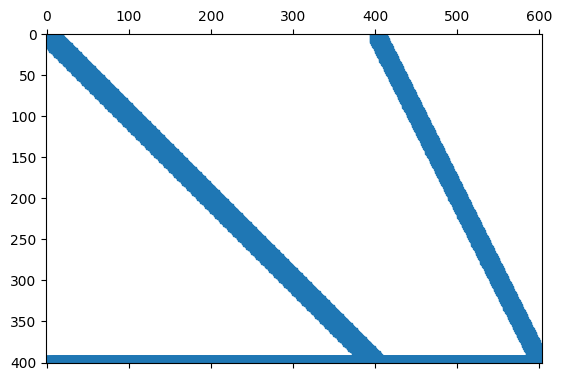

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sps

gdxin = gp.Container()
# must read in domain of A as well
gdxin.read('jac.gdx',['A','i','j','H'])
M = gdxin['A'].toSparseCoo()
plt.spy(M)
plt.show()

We can extract the Hessian for each row of this constraint matrix, but all except last row are zero matrices (since these constraints are linear). 
 
We extract the Hessian of the objective row and see below that the Hessian $H$ is diagonal (since $Q$ and $R$ are diagonal). 

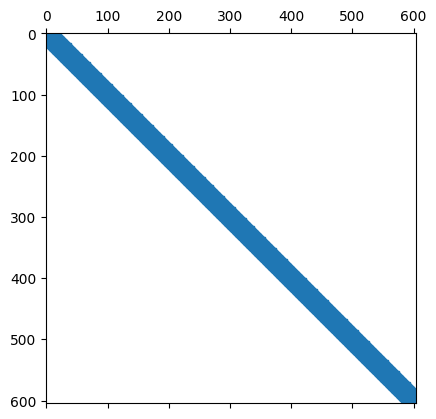

In [5]:
# Hessian is for each row, drop first index and plot
Hess=gdxin['H']
Hess.domain = Hess.domain[1:3]
Hess.records.drop(columns='i_0',inplace=True)
Hess.records.columns=['j_0','j_1','value']
H = Hess.toSparseCoo()
plt.spy(H)
plt.show();

Now run real model.   

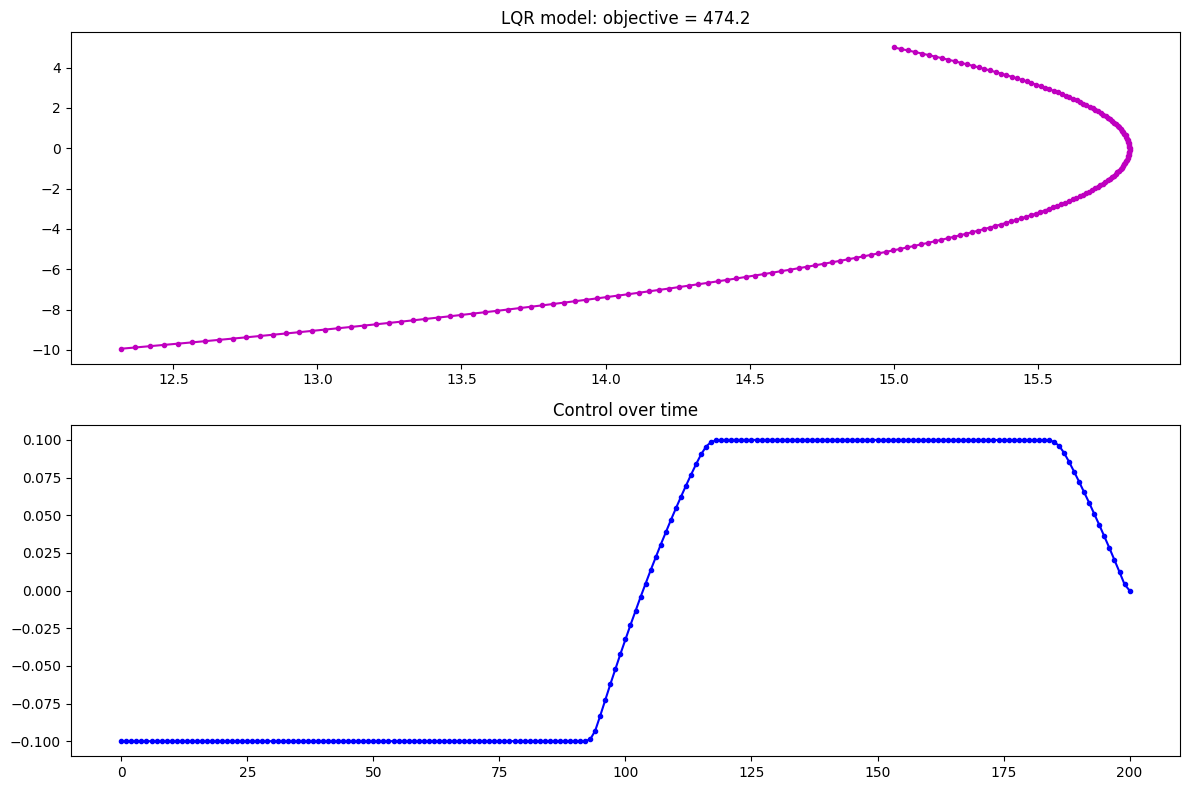

In [6]:
def plot_traj(cost,x,u):
    xval = x.pivot()
    uval = u.pivot()

    fig, ax = plt.subplots(nrows=2,figsize=(12,8))
    # plot the x data
    ax[0].plot(xval['1'],xval['2'],'m.-')
    ax[0].set_title(f'LQR model: objective = {cost:.1f}')
    ax[1].plot(range(0,int(T.toValue())+1),uval['1'],"b.-")
    ax[1].set_title("Control over time")
    fig.tight_layout();

lqr.solve(solver="cplex",output=None)
plot_traj(lqr.objective_value,x,u)

Could also update value of U (0.2, 0.5, etc)

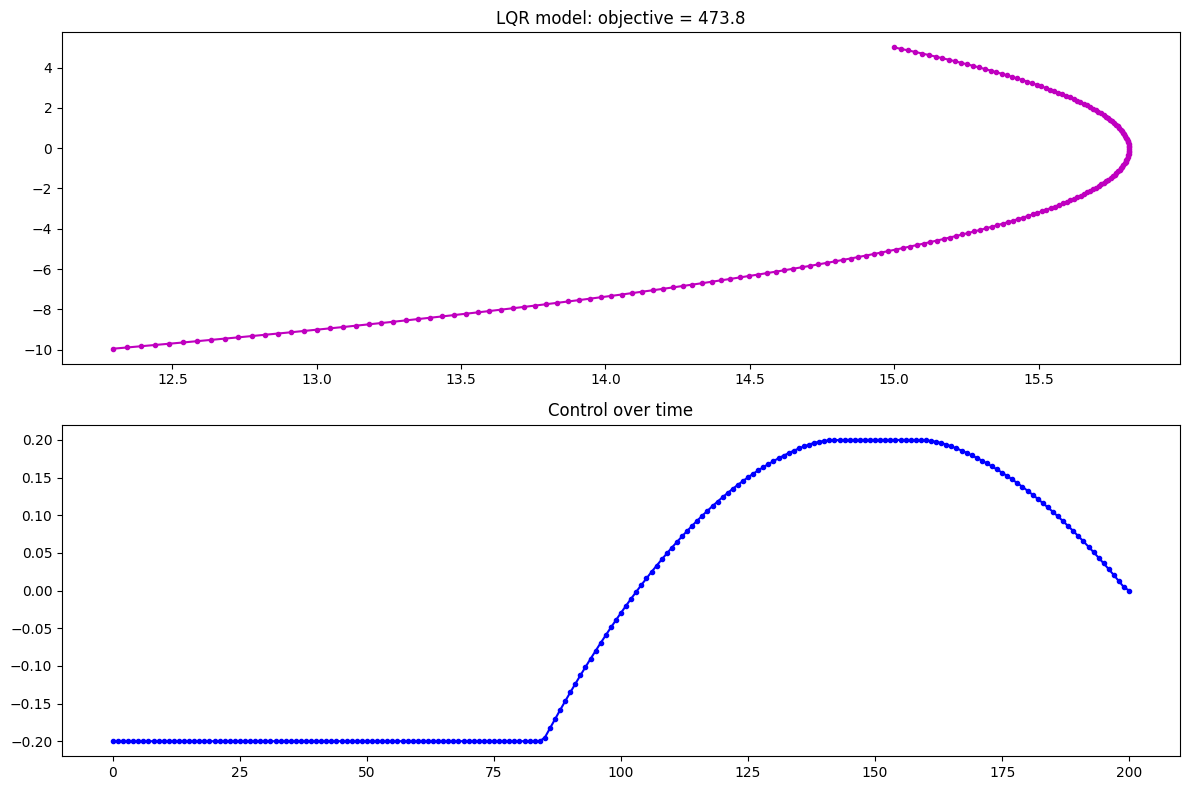

In [7]:
Ubound.setRecords(0.2)

u.up[stages, inputs] = Ubound
u.lo[stages, inputs] = -Ubound

lqr.solve(solver="cplex",output=None)
plot_traj(lqr.objective_value,x,u)